In [2]:
import pandas as pd
import numpy as np
from io import BytesIO, StringIO

class DataCleaner:
    def __init__(self, file_input, filename=None):
        """
        Two ways to initialize:
        1. Provide a file path as a string (e.g., 'data.csv').
        2. Provide an UploadedFile object (e.g., from FastAPI or Streamlit
        """
        self.df = self.load_data(file_input, filename)
        self.report = {"original_rows": len(self.df), "original_cols": len(self.df.columns)}

    def load_data(self, file_input, filename=None):

        if isinstance(file_input, str):
            return self._load_from_path(file_input)

        elif hasattr(file_input, 'read'):
            return self._load_from_uploaded_file(file_input, filename)

        else:
            raise TypeError("Entry must be a file path string or an UploadedFile object")

    def _load_from_path(self, file_path):
        """Load data from a file path"""
        match = file_path.split('.')[-1].lower() if file_path else 'csv'
        if match == 'csv':
            return pd.read_csv(file_path)
        elif match in ['xlsx', 'xls']:
            return pd.read_excel(file_path)


    def _load_from_uploaded_file(self, uploaded_file, filename):
        """Load data from an UploadedFile object"""

        extension = filename.split('.')[-1].lower() if filename else 'csv'


        content = uploaded_file.read()

        if extension == 'csv':

            return pd.read_csv(StringIO(content.decode('utf-8')))
        elif extension in ['xlsx', 'xls']:

            return pd.read_excel(BytesIO(content))
        else:
            raise ValueError("Unsupported file format. Please upload a CSV or Excel file.")

    def auto_clean(self):
        """Execute all cleaning steps"""
        self.clean_headers()
        self.drop_empty()
        self.handle_duplicates()
        self.remove_trims()
        self.fix_data_types()
        self.handle_missing()
        self.remove_constant_columns()
        return self.df, self.report

    def clean_headers(self):
        """Normalize column headers"""
        self.df.columns = (
            self.df.columns
            .str.strip()
            .str.lower()
            .str.replace(' ', '_')
            .str.replace('[^\w]', '', regex=True)
        )
        self.report['renamed_columns'] = list(self.df.columns)

    def drop_empty(self, threshold=0.7):
        """Drop empty columns and rows based on a threshold"""
        # Threshold for dropping columns: if more than 70% of values are null, drop
        col_null_ratio = self.df.isnull().mean()
        cols_to_drop = col_null_ratio[col_null_ratio > threshold].index
        self.df.drop(columns=cols_to_drop, inplace=True)
        self.report['dropped_cols'] = list(cols_to_drop)

        # Threshold for dropping rows: if more than 70% of values are null, drop
        self.df.dropna(thresh=len(self.df.columns)*0.7, inplace=True)
        self.report['remaining_rows'] = len(self.df)

    def handle_duplicates(self):
        """Manage duplicates in the dataset"""
        duplicates = self.df.duplicated().sum()
        self.df.drop_duplicates(inplace=True)
        self.report['duplicates_removed'] = duplicates

    def fix_data_types(self):
        for col in self.df.select_dtypes(include='object'):
            sample_values = self.df[col].dropna().unique()[:5]
            if all(isinstance(v, str) and v.replace('-', '').isdigit() for v in sample_values):
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                self.report.setdefault('converted_to_numeric', []).append(col)
            else:
                try:
                    self.df[col] = pd.to_datetime(self.df[col], errors='raise')
                    self.report.setdefault('converted_to_datetime', []).append(col)
                except:
                    pass


    def handle_missing(self):
        """Handle missing values in the dataset"""
        for col in self.df.columns:
            if self.df[col].isnull().sum() > 0:
                if self.df[col].dtype in ['int64', 'float64']:
                    self.df[col].fillna(self.df[col].median(), inplace=True)
                else:
                    self.df[col].fillna(self.df[col].mode()[0], inplace=True)
                self.report.setdefault('imputed_cols', {})[col] = self.df[col].dtype.name

    def remove_constant_columns(self):
        """Remove columns with constant values (only one unique value)"""
        constant_cols = [col for col in self.df.columns if self.df[col].nunique() == 1]
        self.df.drop(columns=constant_cols, inplace=True)
        self.report['constant_cols_removed'] = constant_cols

    def remove_trims(self):
        """Remove leading and trailing whitespace from string columns"""
        for col in self.df.select_dtypes(include='object'):
            self.df[col] = self.df[col].str.strip()
        # Store the names of trimmed columns in the report
        if 'trimmed_columns' not in self.report:
            self.report['trimmed_columns'] = []
        if 'trimmed_columns' in self.report:
            self.report['trimmed_columns'].extend(
                [col for col in self.df.select_dtypes(include='object').columns if col not in self.report['trimmed_columns']]
            )
        self.report['trimmed_columns'] = list(self.df.select_dtypes(include='object').columns)

In [3]:
class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        self.summary = {}

    def describe_numeric(self):
        """Sayısal kolonların istatistiksel özetini döner"""
        numeric_summary = self.df.describe().T
        self.summary['numeric_summary'] = numeric_summary
        return numeric_summary

    def describe_categorical(self):
        """Kategorik kolonların sınıf sayısı ve en sık görüleni"""
        cat_cols = self.df.select_dtypes(include='object').columns
        cat_summary = pd.DataFrame(columns=['Unique Values', 'Top Value', 'Top Frequency'])

        for col in cat_cols:
            unique_vals = self.df[col].nunique()
            top_value = self.df[col].mode()[0]
            top_freq = self.df[col].value_counts().iloc[0]
            cat_summary.loc[col] = [unique_vals, top_value, top_freq]

        self.summary['categorical_summary'] = cat_summary
        return cat_summary

    def missing_values(self):
        """Eksik değer sayı ve oranlarını getirir"""
        missing = self.df.isnull().sum()
        missing_ratio = (missing / len(self.df)) * 100
        missing_df = pd.DataFrame({'Missing Values': missing, 'Missing Ratio (%)': missing_ratio})
        missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)
        self.summary['missing_values'] = missing_df
        return missing_df

    def get_summary_report(self):
        """Tüm raporları sözlük formatında döner"""
        return self.summary

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class DataVisualizer:
    def __init__(self, df):
        self.df = df

    def plot_numeric_distributions(self):
        """Sayısal kolonların histogram grafikleri"""
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        for col in num_cols:
            plt.figure(figsize=(8, 4))
            sns.histplot(self.df[col].dropna(), kde=True)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()

    def plot_categorical_counts(self):
        """Kategorik kolonların bar grafikleri"""
        cat_cols = self.df.select_dtypes(include='object').columns
        for col in cat_cols:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=col, data=self.df, order=self.df[col].value_counts().index)
            plt.title(f'Count of {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
            plt.show()

    def correlation_heatmap(self):
        """Sayısal kolonlar arasındaki korelasyon matrisi"""
        corr = self.df.corr(numeric_only=True)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title('Correlation Heatmap')
        plt.show()

/tmp/ipython-input-2-603669929.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[col] = pd.to_datetime(self.df[col], errors='raise')
/tmp/ipython-input-2-603669929.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[col] = pd.to_datetime(self.df[col], errors='raise')
/tmp/ipython-input-2-603669929.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[col] = pd.to_datetime(self.df[col], errors='raise')
/tmp/ipython-input-2-603669929.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateuti

                             count          mean           std       min  \
rank                         234.0  1.175000e+02  6.769417e+01    1.0000   
2022_population              234.0  3.413876e+07  1.367519e+08  510.0000   
2020_population              234.0  3.348044e+07  1.355938e+08  520.0000   
2015_population              234.0  3.160752e+07  1.304200e+08  564.0000   
2010_population              234.0  2.951092e+07  1.242415e+08  596.0000   
2000_population              234.0  2.617193e+07  1.117019e+08  651.0000   
1990_population              234.0  1.899831e+07  8.046401e+07  700.0000   
1980_population              234.0  1.600195e+07  6.862384e+07  733.0000   
1970_population              234.0  1.563821e+07  6.778878e+07  752.0000   
area_km²                     234.0  5.773516e+05  1.762139e+06    1.0000   
density_per_km²              234.0  4.506328e+02  2.066310e+03    0.0261   
growth_rate                  234.0  1.009539e+00  1.333357e-02    0.9120   
world_popula

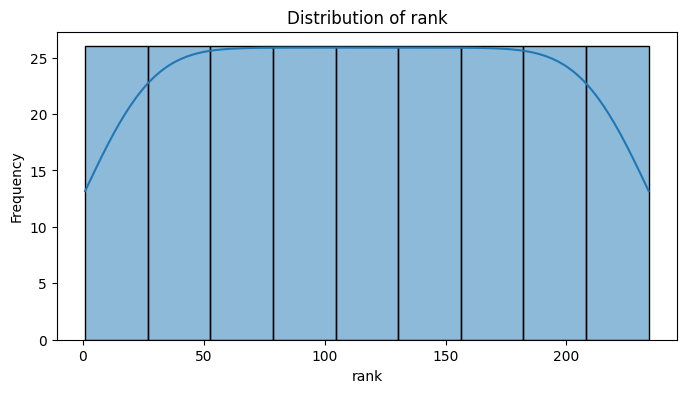

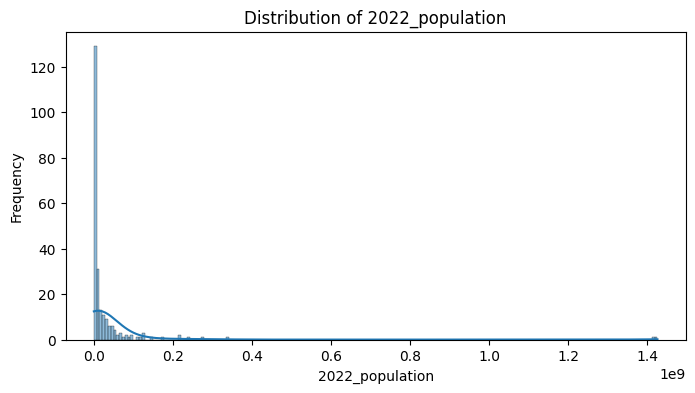

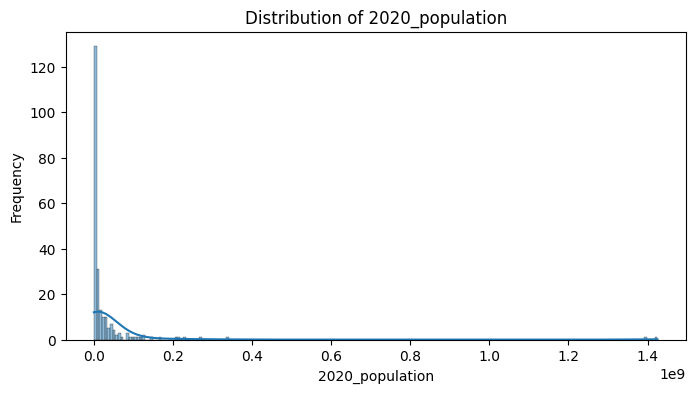

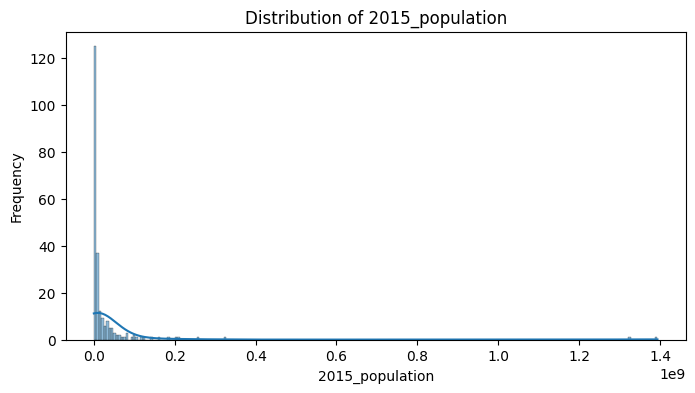

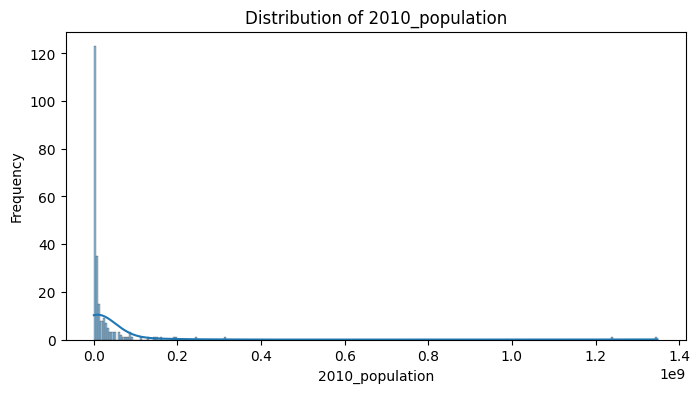

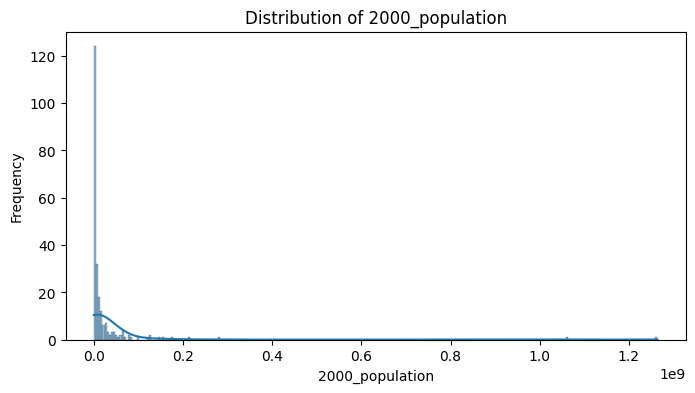

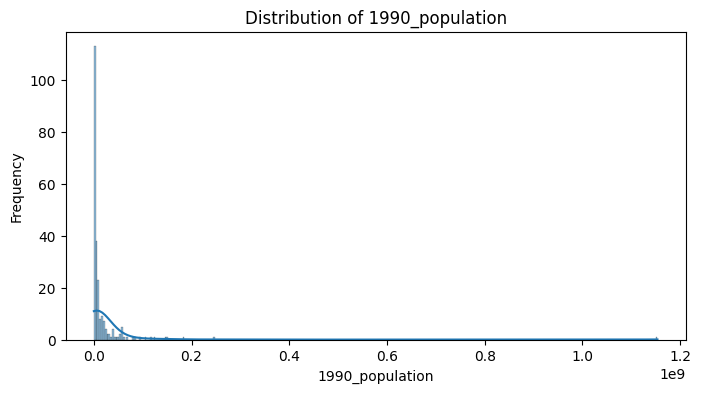

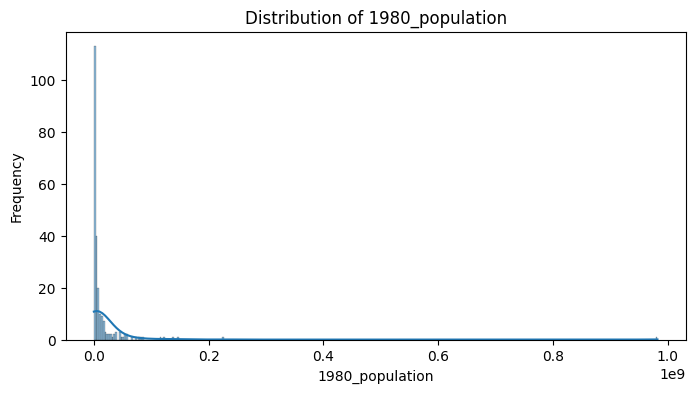

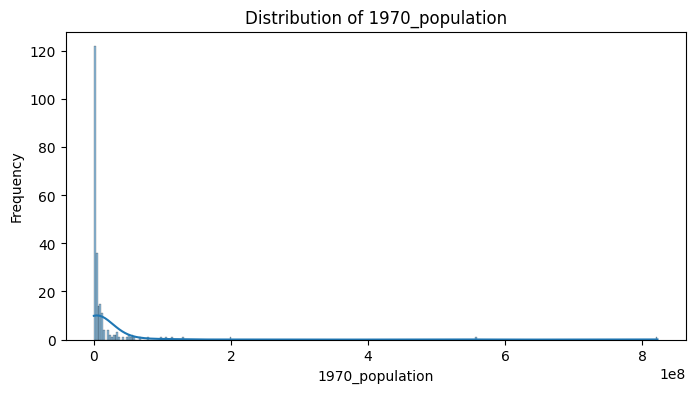

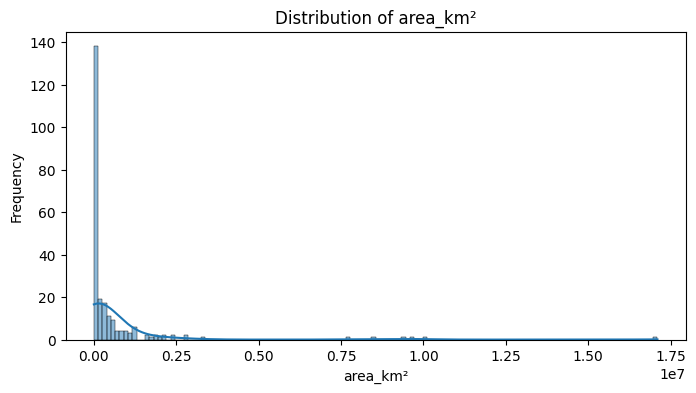

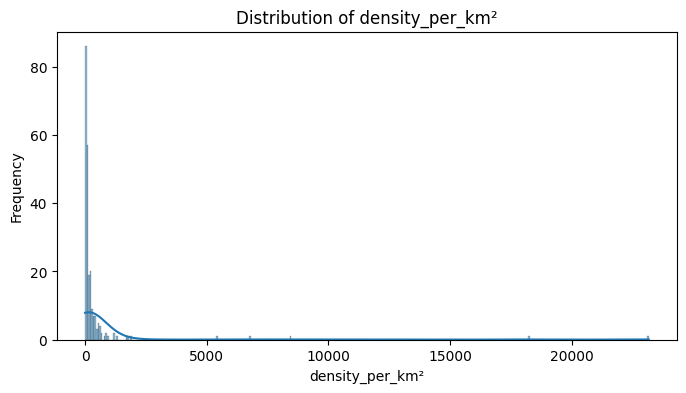

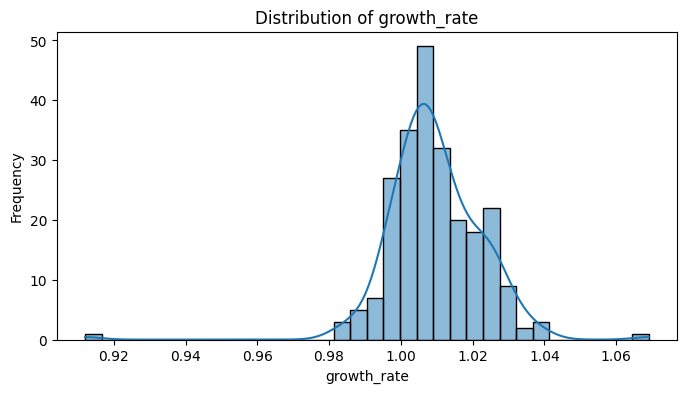

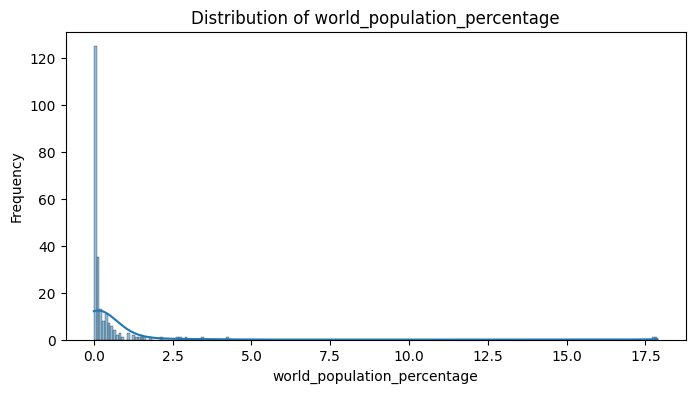

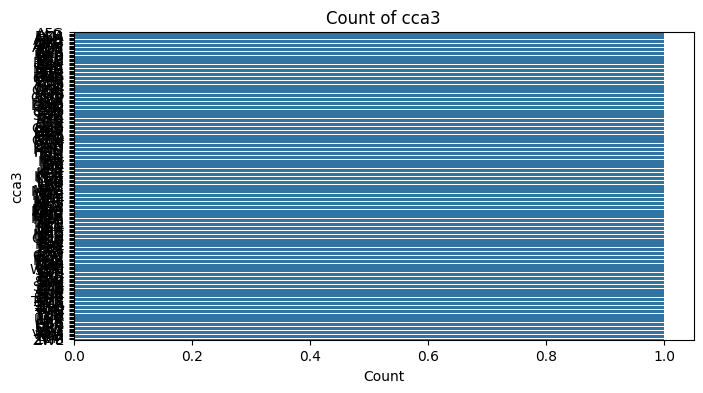

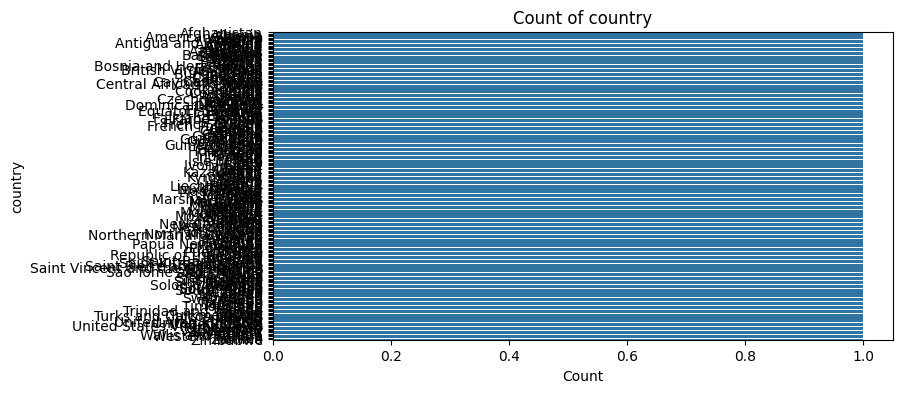

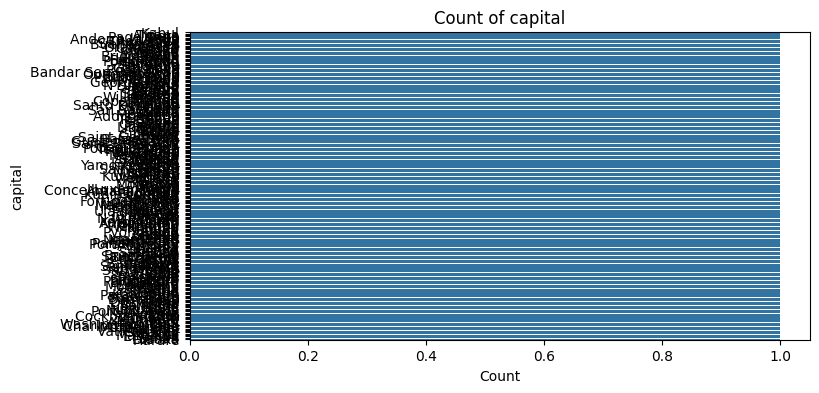

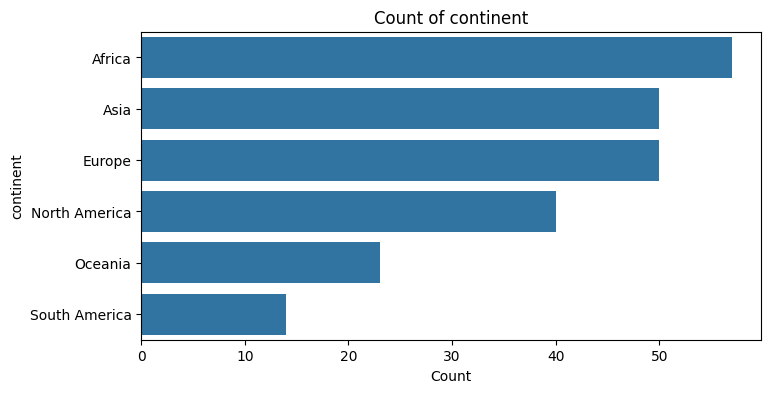

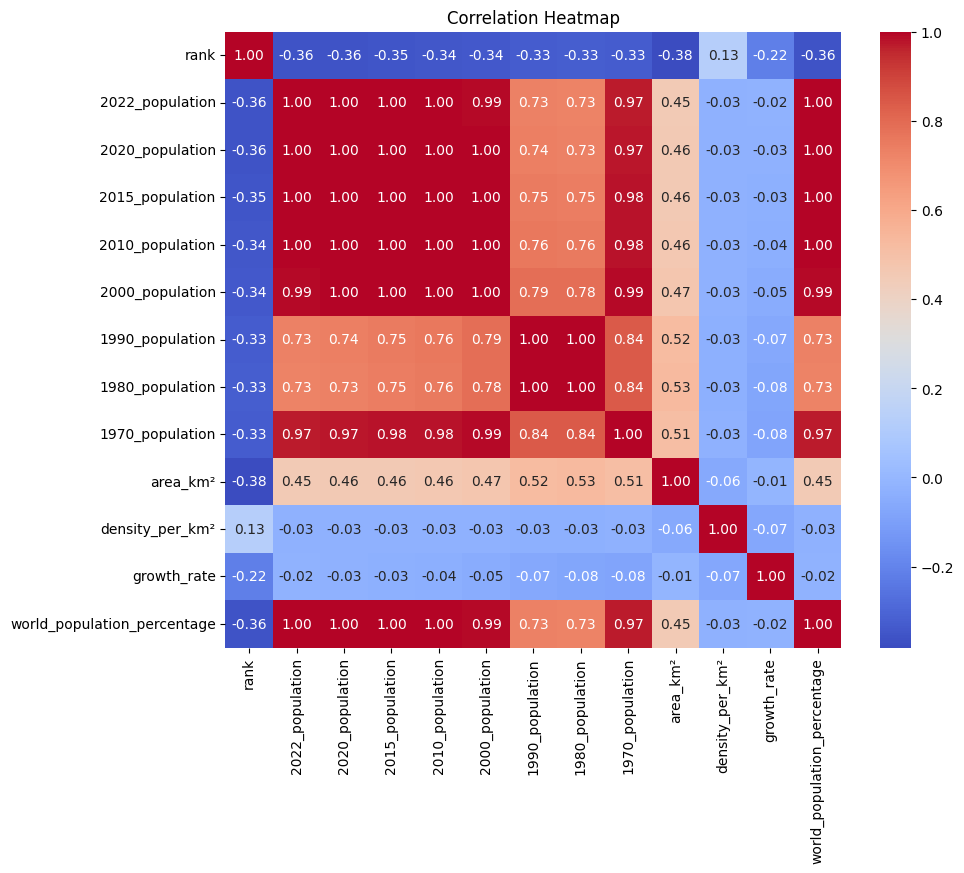

In [6]:
# Data temizleme
cleaner = DataCleaner('/content/world_population.csv')
df_clean, report = cleaner.auto_clean()

# EDA analizi
analyzer = DataAnalyzer(df_clean)
print(analyzer.describe_numeric())
print(analyzer.describe_categorical())
print(analyzer.missing_values())

# Grafik
visualizer = DataVisualizer(df_clean)
visualizer.plot_numeric_distributions()
visualizer.plot_categorical_counts()
visualizer.correlation_heatmap()